# Numpy: beyond the basics
In the first notebook in this series, we covered the bare minimum you probably need to know in order to start using numpy productively: creating arrays, restructuring them, and operating on them using many of the tools available in the numpy package. In this second notebook, we'll introduce a couple more concepts that can help you write more efficient, robust numpy code. Then we'll end with some tips to keep in mind when working with numpy.

Let's start with some imports:

In [1]:
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
%matplotlib inline

### Broadcasting
In the previous section, in all of our examples involving operations on two arrays (e.g., subtracting one array from another, replacing a subset of one array with another array, etc.), we made sure that both arrays had exactly the same shape. To remind you, we did things like this:

In [2]:
arr_2d = np.zeros((5, 5))
ones = np.ones((3, 3))
arr_2d[:3, 2:] = ones

arr_2d

array([[0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

Here we replace a 3 x 3 sub-array with another 3 x 3 array. The two arrays have the same shapes, so we don't encounter any problems. If we had mismatching shapes, bad things would happen. As an **exercise**, you can verify this by playing around with the size of the replacement array in the above example (i.e., modify `ones` so it doesn't have shape `(3, 3)`) and see what happens.

You might come away thinking that the shapes of two arrays *always* have to match perfectly. But this isn't quite true. If the size of one array can be made to match that of the other by repeating the replacement value multiple times along one of the axes of the target, then the operation will work, as long as we follow certain rules. The process of repeating one array to make it fit into the dimensions of another one is called *broadcasting*. Broadcasting isn't a very intuitive concept, so don't worry if it doesn't make sense at first. A detailed explanation of its rules can be found [here](https://numpy.org/doc/stable/user/basics.broadcasting.html). But broadcasting does play an important implicit role in many of the operations we're about to cover, so it's important to get at least a bit of the flavor. Let's work through a couple of examples.

First, it's useful to know that *any* size of target array can always be replaced with a single value, because we can always repeat the same value as many times as we need to in order to fill an array:

In [3]:
arr_2d = np.zeros((5, 5))
arr_2d[:3, 2:] = np.nan

arr_2d

array([[ 0.,  0., nan, nan, nan],
       [ 0.,  0., nan, nan, nan],
       [ 0.,  0., nan, nan, nan],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

This is extremely useful, as it's very common to want to replace a whole bunch of numbers in an array with a single value. In the above example, we assign the special value `nan` (which stands for "not a number") to a 3 x 3 sub-array of our 5 x 5 array, which in many contexts might denote that those values are invalid, missing, or otherwise shouldn't be used in further analysis.

Here's a more complex example of broadcasting:

In [4]:
arr_2d = np.zeros((6, 6))
replacement = np.array([1, 4])
arr_2d[:, 2:4] = replacement
arr_2d

array([[0., 0., 1., 4., 0., 0.],
       [0., 0., 1., 4., 0., 0.],
       [0., 0., 1., 4., 0., 0.],
       [0., 0., 1., 4., 0., 0.],
       [0., 0., 1., 4., 0., 0.],
       [0., 0., 1., 4., 0., 0.]])

Here we're replacing a sub-array of shape `(6, 2)` with an array of shape `(2,)`. This works fine, because the replacement shape and the target shape are compatible; we can make the replacement fit the target by repeating it 6 times along the first axis of the array.

**Exercise**: replace the `replacement` array above with another array that has a different shape (i.e., not `(2,)`), but still broadcasts successfully to the target shape of `(6, 2)`. *Hint*: you might need to add a second dimension to the replacement.

## Advanced indexing
In part 1, we explored various ways of indexing numpy arrays. Now we'll look at a couple of more advanced ones.

### Indexing arrays with arrays
Numpy arrays can be used to index other numpy arrays. Let's dive right into an example:

In [5]:
x = np.arange(8) ** 2
print("Array to be indexed:", x)

i = np.array([[2, 6], [1, 3]])

print("\nResult of indexing with a 2 x 2 array:\n", x[i])

Array to be indexed: [ 0  1  4  9 16 25 36 49]

Result of indexing with a 2 x 2 array:
 [[ 4 36]
 [ 1  9]]


What's happening here is that each value in the indexing array `i` is interpreted as the index of the desired value in `x`. Note that `x` is 1-dimensional, and the resulting array has the same shape as the indexer. Because `x` has only 8 elements, if we pass in an indexing array with a value higher than 7, numpy will complain (feel free to try).

If the target array has more than 1 dimension, things get a little trickier. We now pass multiple index arrays—one per dimension of the target:

In [6]:
x = np.reshape(np.arange(16), (4, 4))

print("Array to be indexed:\n", x)

i = np.array([[0, 3], [1, 2]])
j = np.array([[1, 1], [3, 3]])

print("\nResult of indexing:")
print(x[i, j])

Array to be indexed:
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]

Result of indexing:
[[ 1 13]
 [ 7 11]]


Here, `i` contains the indices for the first dimension of `x`, and `j` contains the indices for the second dimension.

### Boolean indexing
Numpy arrays can be indexed with boolean arrays. This approach can be incredibly useful, as it lets us easily select (or update) subarrays that meet arbitrary logical conditions.

Let's return to the MNI152 2mm anatomical image we worked with in part 1:

In [7]:
import nibabel as nib

img = nib.load('data/anatomical.nii.gz')
data = img.get_fdata()

Suppose we want to identify all the voxels in the image with values greater than 7000:

In [8]:
is_big = data > 7000

Now, `is_big` is a boolean array with value `True` at those positions where the value in `data` was greater than 7000, and `False` at all positions where it was less than or equal to 7000.

Now we can use this array as an index in the original `data` array. For example, we can retrieve only the voxels with values > 7000 as a 1-dimensional array:

In [9]:
big_values = data[is_big]

big_values.shape

(50465,)

There are 50,465 voxels in the image with values > 7000 (out of over 900,000 in the full volume). Note that only those positions marked `True` in the index will be returned.

We can also selectively update values in one array using a boolean index. Let's set all the voxels in our image with values less than or equal to 7,000 to 0. In effect, we're filtering out all but the largest values in the image.

In [10]:
# Copy the original image to prevent modification
filtered = data.copy()

# Set all voxel values <= 7000 to 0.
# The ~ operator means NOT.
filtered[~is_big] = 0

filtered.shape

(91, 109, 91)

The new image has the same shape as the old one. It should, because it's just a copy of the old image, but with values less than or equal to 7,000 set to 0. It's easiest to understand what we just did by visualizing the two images side-by-side:

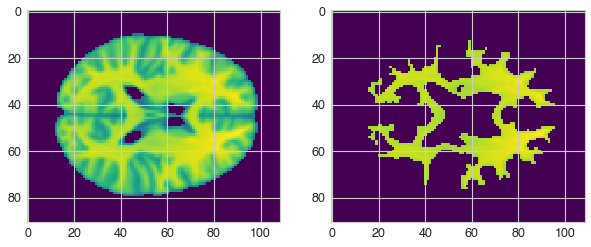

In [11]:
import matplotlib.pyplot as plt

orig_slice = data[:, :, 45]
filt_slice = filtered[:, :, 45]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(orig_slice);
axes[1].imshow(filt_slice);

Most of what's left is white matter, which has higher MR intensities in our image. As an **exercise**, you can invert the filtering step and keep only the smaller values in the image.

## Tips and tricks
Numpy is an extremely powerful package, and what we've covered so far only scratches the surface. Here we'll just briefly cover just a few more tips, tricks, and common pain points that are worth being aware of.

### Vectorization
Numpy arrays are iterable structures, and as such, we're always free to loop over elements in arrays just the way we could with Python lists. For example, instead of using element-wise array arithmetic to add a constant to each value of an array like this:

In [12]:
x = np.arange(5)

x + 2.2

array([2.2, 3.2, 4.2, 5.2, 6.2])

We could write out an explicit for-loop like this:

In [13]:
y = np.zeros((5,))

for i in range(5):
    y[i] = x[i] + 2.2

y

array([2.2, 3.2, 4.2, 5.2, 6.2])

You might naively suppose that these two approaches are computationally identical, and the first one just happens to involves less typing. But actually, the two are very different under the hood. The first approach is *vectorized*, meaning, instead of applying some operation to each element in an array individually, we perform the same computation on multiple values simultaneously.

In general, vectorization in numpy will be considerably more efficient than naive iteration--sometimes by orders of magnitude. The reason for this is that, unlike compiled languages like C, Fortran, or Julia, loops in Python (a dynamically typed language) impose considerable computational overhead. When we write a loop over an array with multiple elements, the Python interpreter has to check the type of each of the elements individually before it can operate on them. While this overhead is very small individually, it adds up quickly if we're looping over millions or billions of values. By contrast, because numpy arrays are homogeneously typed, the type of the array only needs to be inspected once.

The upshot is that while naive for-loops are a very efficient way to proceed when writing code in a compiled language, they should be avoided whenever possible when writing numpy code in Python. One of the most effective ways to improve the performance of your numpy code when you're first starting out is to sweep through it and replace as many of the for-loops as you can with vectorized versions of the same operations. (There are also other techniques like just-in-time compilation and Cython that can provide dramatic speed-ups even when using naive loops; we cover some of these in the "High-performance Python" lecture.)

### Copies vs. views
Most numpy functions return arrays that are derived in some way from other existing arrays. In nearly all cases, the result is an entirely new array, and any arrays passed to the function as input are left unmodified:

In [14]:
x = np.arange(5)
print("Value of x after assignment:", x)

y = np.multiply(x, 2)
print("Value of x after multiplication and assignment to y:", x)

Value of x after assignment: [0 1 2 3 4]
Value of x after multiplication and assignment to y: [0 1 2 3 4]


In the above example, we multiply `x` by 2 before assigning the result to `y`, but the value of `x` itself doesn't change as a result of the multiplication. What happens is that the `np.multiply()` function creates a *copy* of the `x` array, multiples it by 2, and then returns the result. There will be no change to the value stored at `x` unless we explicitly re-assign the result to `x` (i.e., `x = np.multiply(x, 2)`). Most users find this behavior intuitive: it would cause us all kinds of problems if every transformation we applied to an array automatically resulted in a permanent change to the value stored at the corresponding variable.

What might be less intuitive is that some numpy operations on an array do *not* return a copy of that array. For example, slicing an array won't return a copy, and neither (in most cases) will `np.reshape()`. Instead, these operations return something called a *view*. A view, as the name suggests, gives us a different way of seeing the array; however, the underlying data the variable refers to remain the same. This means that any changes we make to a view will be immediately reflected in the original array:

In [15]:
x = np.zeros((4, 4))

view_x = x[:2, :2]

view_x[:] = 1

x

array([[1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

Observe that in this case, modifying `view_x` (a view of the array `x`) also changed the data in `x`!

The fact that array slicing returns views rather than copies is usually a good thing, as we often need to work with many views of the same data, and creating a new array every time we want a view of a different part of the data would be inefficient. But it's important to remember that any changes made to a view will propagate through to the array being viewed. In cases where we want to avoid this, we can explicitly call `copy()` on a view to ensure that we're working with an entirely new array:

In [16]:
x = np.zeros((4, 4))

view_x = np.copy(x[:2, :2])

view_x[:] = 1

x

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

### Object-oriented syntax
The examples we've worked through so far all use a functional syntax when manipulating numpy arrays. For example, if we want to sum the elements of an array, we call `np.sum(x)`, where `sum()` is a function defined in the numpy namespace, and `x` is the array we want to sum. If we want to stack operations, we can nest functions inside one another. The expression `np.max(np.sum(x, axis=0))` would first sum the `x` array along its first axis, and then take the maximum value of the resulting array.

There's absolutely nothing wrong with this syntax, and readers with prior experience in other data-centric languages like R or MATLAB might find it very natural to write this kind of code. That said, Python is a deeply object-oriented programming language, and many Python programmers prefer an object-oriented syntax, where most functionality is accessed via attributes of an object rather than as stand-alone functions available in the current namespace. Numpy respects this preference by providing object-oriented access to some of the most common functions in the root numpy namespace. This means that we can equivalently write the expression `np.max(np.sum(x, axis=0))` as `x.sum(axis=0).max()`.

There's rarely a meaningful difference between these two syntaxes under the hood, so the choice between them mostly boils down to aesthetic preference and/or economy (e.g., `x.T` is easier to type than `np.transpose(x)`). Just be aware that both syntaxes are common in the wild, so even if you stick with a purely functional syntax in your own code, you should expect to run into the object-oriented notation when reading other people's.